# Let's start with the old code.

We will construct the **old** code but **prettify** it to match the "pytorch standards".

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.functional import cross_entropy
from torch.nn.functional import softmax

# `1.` Data loading 

In [3]:
# Load the data
with open("./names.txt", "r") as file:
    names = file.read().splitlines()
    
# total unique characters
characters = sorted(list(set(''.join(names))))

# Builind index-to-char and char-to-index
number_to_chr = {k:v for k, v in enumerate(["<", ">"] + characters)}
chr_to_number = {v:k for k, v in enumerate(["<", ">"] + characters)}

In [4]:
# This function will build the dataset and return the X, Y
# Used when we have multiple splits :)
block_size = 3
def build_dataset(shuffled_names):
    sot = chr_to_number["<"]

    X = []
    y = []

    for name in shuffled_names: #FOR ALL NAMES
        window_chars = [sot] * block_size
        name = name + ">" 

        for ch in name:
            _3chars = ''.join(
                list(
                    map(lambda x:number_to_chr[x], window_chars)
                )) 
            ch_index = chr_to_number[ch]

            X.append(window_chars)
            y.append(ch_index)
            window_chars = window_chars[1:] + [ch_index]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

import random
random.seed(42)
random.shuffle(names) # In-place shuffling. No longer first word will be "emma"

train_idx = int(0.8 * len(names)) # 80%
val_idx = int(0.9 * len(names)) # 90% - 80% = 10%

Xtrain, ytrain = build_dataset(names[:train_idx])
Xval, yval = build_dataset(names[train_idx:val_idx])
Xtest, ytest = build_dataset(names[val_idx:])

print(f"* {Xtrain.shape = }\n* {Xval.shape = }\n* {Xtest.shape = }")

* Xtrain.shape = torch.Size([182625, 3])
* Xval.shape = torch.Size([22655, 3])
* Xtest.shape = torch.Size([22866, 3])


# `2.` Pytorchizing

## Creating a linear class 

In [5]:
class Linear:
    """
    This will be used to create a Linear Layer of `n_ins` and `n_outs`
    and also performs the matrix multiplication
    
    - Possible to enable/disable the bias
    - Automatically set the weights and initialize them with Kaiming
    """
    
    def __init__(self, n_ins, n_outs, bias=True):
        self.weight = torch.randn(n_ins, n_outs, generator=generator) / n_ins**0.5
        self.bias = torch.zeros(n_outs) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

We cool?


## Creating a BatchNorm class 

In [174]:
class BatchNorm1d:
    """
    This will implement the whole batchnorm stuff that can later be added 
    with the linear layer.
    
    - Perform normalization
    - Keep track of the statistics of the batch "while" training and while evaluation
    - Distinction between training and evaluation/inference
    """
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """
        `eps`: Adds a small number in the denomenator while standardizing to
            avoid division by zero error
            
        `momentum`: Used in the calculation of the statistics while training
            to set the effect of how much of the std and mean to keep from the
            current batch. High mementum means learn more and visaversa.
        """
        
        self.dim = dim
        self.eps = eps
        self.momentum = momentum
        self.training = True # Will be explained later in a bit below.
        
        ### For scaling & shifting
        # Sacler will be called `gamma`
        # Shifter will be called `beta`
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        ### Keep track of running mean and variance for the inference!
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
        
    def __call__(self, x):   
        ### If `training` then calculate the mean and var 
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        ### If `not training` then use the running mean and var
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        ### Normalize!
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        ### Calculate the running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

This code:
```python
if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * running_var + self.momentum * xvar
        return self.out
```

If it is not clear, don't worry. 
- Here we are simply calculating the mean and variance from the training and saving them so that later **while the inference** it can be used
- The way it is learnt is called "exponential smoothing average" or "EWMA". 

> 🤗 <br>I have made a comprehensive guide on exponential smoothing (EWMA) in my [time-series repository](https://github.com/AayushSameerShah/TimeSeries-Forecasting/blob/main/2.%20Exponential%20Smoothing%20and%20ETS/3.%20EWMA.ipynb) *(direct link to that topic)*.

## Creating a Tanh class 

In [7]:
class Tanh:
    """
    Just to calculate the `tanh`
    """
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# `3.` Building an NN 

In [8]:
n_embd = 10
n_neurons = 100
vocab_size = len(number_to_chr) # 28
generator = torch.Generator().manual_seed(42)

In [9]:
embeddings = torch.randn(vocab_size, n_embd, generator=generator)

## The first pytorchized code
layers = [
    Linear(n_embd * block_size, n_neurons), 
    Tanh(),
    Linear(n_neurons, n_neurons), 
    Tanh(),
    Linear(n_neurons, n_neurons), 
    Tanh(),
    Linear(n_neurons, n_neurons), 
    Tanh(),
    Linear(n_neurons, n_neurons), 
    Tanh(),
    Linear(n_neurons, vocab_size), 
]

> **NOTE**: Here instead of a single layer, we have taken `4` hidden layers.

In [10]:
with torch.no_grad():
    # Scrutinizing - 1 effect: Make the outputs less confident
    layers[-1].weight *= 0.1 # the magic number ;)
    
    # Use the gain 5/3 for all layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [11]:
parameters = [embeddings]
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)

In [12]:
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46608


# `4.` Trigger training!

> 📝 <br> **NOTE**: We are **not** using the batch normalization currently in this code. We are simply running the code without any kind of standardization, so keep that in mind.

In [13]:
epochs = 1
batch_size = 32
losses = []

In [14]:
for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = cross_entropy(x, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for layer in layers:
        layer.out.retain_grad() ### Just temproary
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization

In [15]:
losses

[3.3390865325927734]

Have a look! **How clean** the code has become now!

# `5.` Main Thing. How numbers are distributed?

### Gradients' distribution 

Layer[1] — mean: 0.04	std: 0.79	saturation: 26.06%
Layer[3] — mean: 0.01	std: 0.7	saturation: 11.94%
Layer[5] — mean: -0.02	std: 0.67	saturation: 8.16%
Layer[7] — mean: -0.03	std: 0.65	saturation: 5.00%
Layer[9] — mean: 0.03	std: 0.67	saturation: 6.06%


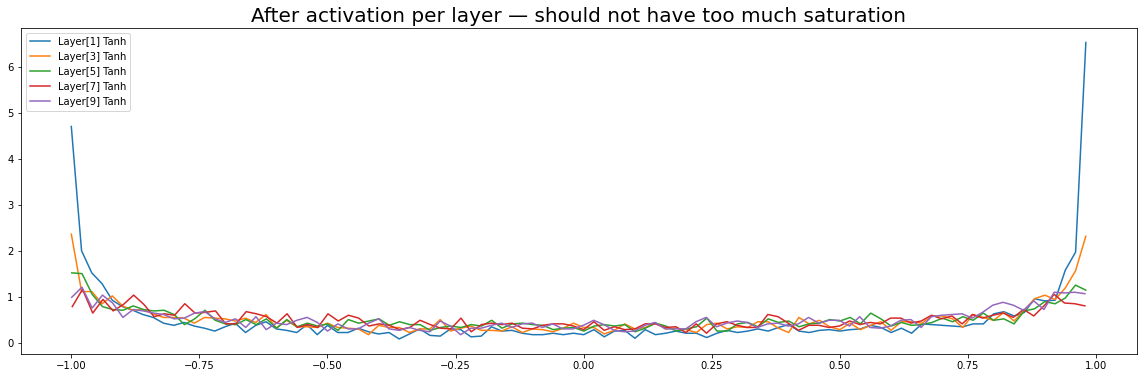

In [16]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        activation_applied = layer.out # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}\tsaturation: {(activation_applied.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("After activation per layer — should not have too much saturation", fontsize=20);

Okay! The **interpretation**:
- The saturation shows *"how much percentage of neurons have value > .97"* which eventually endup being dead.
- The very first layer has chances of it 21% neurons to become dead 💀
- Then the number falls ending with the lowest chances of dead neurons in the last layer - **the reason is the gain 5/3**.
- If we **didn't have used the gain**, the plot would have looked like this ↙


<img src="./Images/use_1_gain.png">

**This**:
- Basically uses the *"default"* value `n_ins**0.5` in the initialization
- So after the first layer, all other layers are getting the *smaller* values and `tanh` making them close to zero. Which is not good, the model needs to keep values "well behaved", not close to zero and not too much extreme.
- **That's where** the `5/3` ***helps and fights this squashing***, by balancing the values.

___
👉 The following is the plot of **the gradients** of Tanh layers look like.  And there is **no point of using the saturation**, so removed it.

Layer[1] — mean: -0.00	std: 0.00039
Layer[3] — mean: -0.00	std: 0.0004
Layer[5] — mean: -0.00	std: 0.00036
Layer[7] — mean: 0.00	std: 0.00034
Layer[9] — mean: 0.00	std: 0.00031


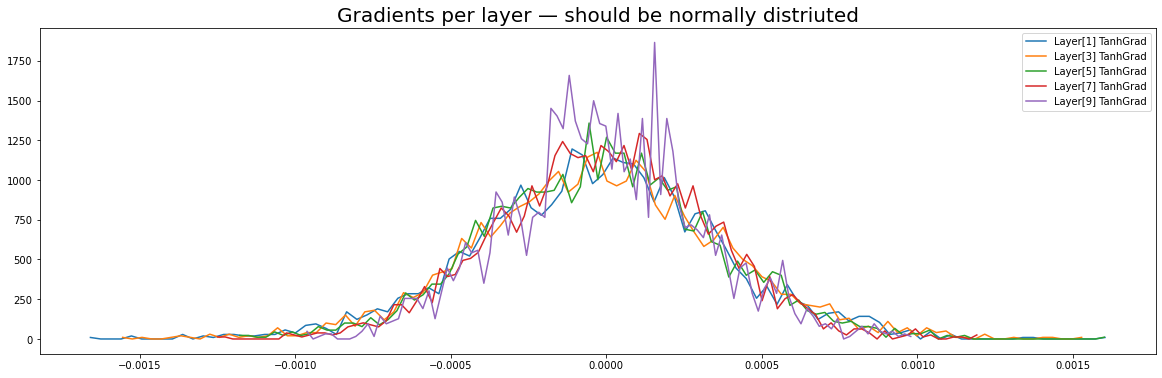

In [17]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        activation_applied = layer.out.grad # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] TanhGrad")
plt.legend(legends)
plt.title("Gradients per layer — should be normally distriuted", fontsize=20);

The gradients are too well behaved

___
The following is the plot of **how the linear** layers look like **without activations**. Here is not point of using the "saturation", so removed it.

Layer[0] — mean: 0.12	std: 1.9
Layer[2] — mean: 0.01	std: 1.4
Layer[4] — mean: -0.04	std: 1.2
Layer[6] — mean: -0.04	std: 1.1
Layer[8] — mean: 0.04	std: 1.1


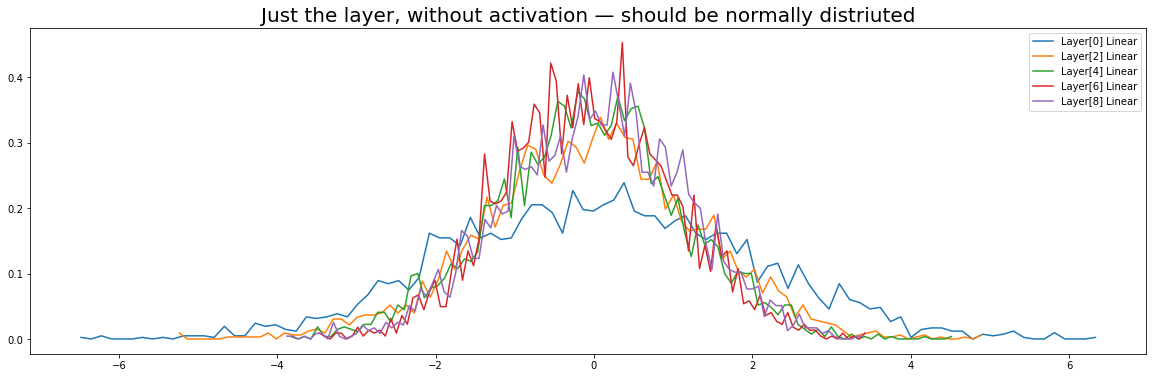

In [18]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        activation_applied = layer.out # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Linear")
plt.legend(legends)
plt.title("Just the layer, without activation — should be normally distriuted", fontsize=20);

## When the things don't look working out:
1. Check if the activation layers are not too extreme, saturation. Fix them by using **gains**
2. Check if the gradients are normally distributed.

> 😰 **Without BatchNorm** till now, we need to be **much more careful** about the gain setting, other wise the activations and the gradient distribution will ne way off.

# 🎭 The neural net won't learn complex things if... 
I am *glad* that Andrej addressed this here, at this point. 

> There is the core question: **Why to use the activations in the first place**?

Let's see what happens **without using the activations**.

### `1.` With Gain

In [19]:
embeddings = torch.randn(vocab_size, n_embd, generator=generator)
layers = [
    Linear(n_embd * block_size, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, vocab_size), 
]

In [20]:
with torch.no_grad():
    layers[-1].weight *= 0.1
    
    ### Still keeping the gain...
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [21]:
parameters = [embeddings]
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)
        
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46608


Trigger training!

In [22]:
losses = []
for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = cross_entropy(x, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for layer in layers:
        layer.out.retain_grad() ### Just temproary
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization

In [23]:
losses

[4.107925891876221]

The numbers...

Layer[0] — mean: 0.03	std: 1.6
Layer[1] — mean: 0.11	std: 2.6
Layer[2] — mean: -0.08	std: 4.2
Layer[3] — mean: 0.07	std: 7.1
Layer[4] — mean: -0.48	std: 1.2e+01


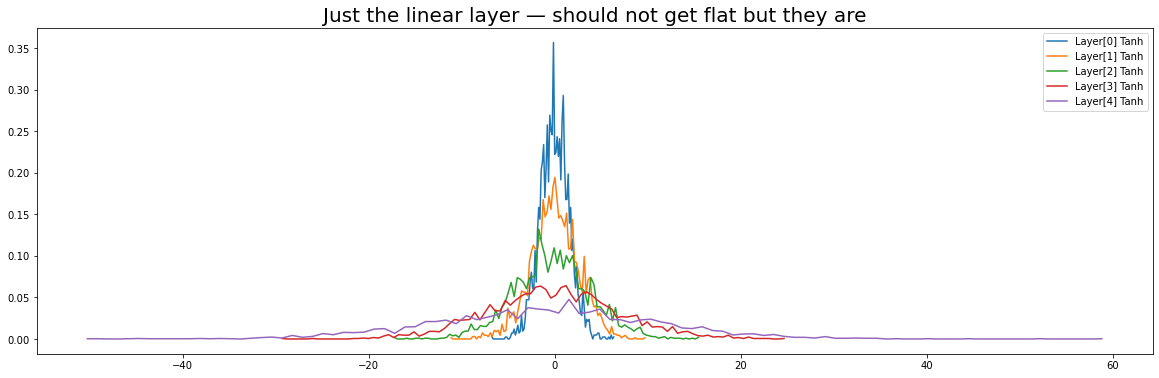

In [24]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        activation_applied = layer.out # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("Just the linear layer — should not get flat but they are", fontsize=20);

Layer[0] — mean: 0.00	std: 0.0025
Layer[1] — mean: -0.00	std: 0.0016
Layer[2] — mean: -0.00	std: 0.00091
Layer[3] — mean: 0.00	std: 0.00055
Layer[4] — mean: 0.00	std: 0.00032


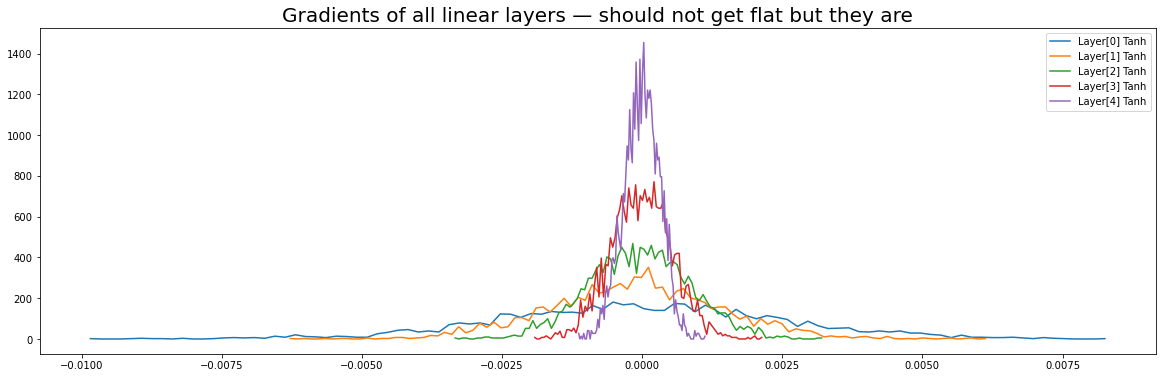

In [25]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        activation_applied = layer.out.grad # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("Gradients of all linear layers — should not get flat but they are", fontsize=20);

### `2.` Without Gain

In [88]:
embeddings = torch.randn(vocab_size, n_embd, generator=generator)
layers = [
    Linear(n_embd * block_size, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, vocab_size), 
]

In [89]:
with torch.no_grad():
    layers[-1].weight *= 0.1
    
    ### No gain was added... keeping the gain...
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 ### SEE?

In [90]:
parameters = [embeddings]
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)
        
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46608


Trigger training!

In [91]:
losses = []
for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = cross_entropy(x, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for layer in layers:
        layer.out.retain_grad() ### Just temproary
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    losses.append(loss.item()) # for better visualization

In [92]:
losses

[3.3164029121398926]

The numbers...

Layer[0] — mean: 0.02	std: 1.1
Layer[1] — mean: 0.04	std: 1.1
Layer[2] — mean: 0.04	std: 1.2
Layer[3] — mean: -0.01	std: 1.1
Layer[4] — mean: 0.00	std: 1.1


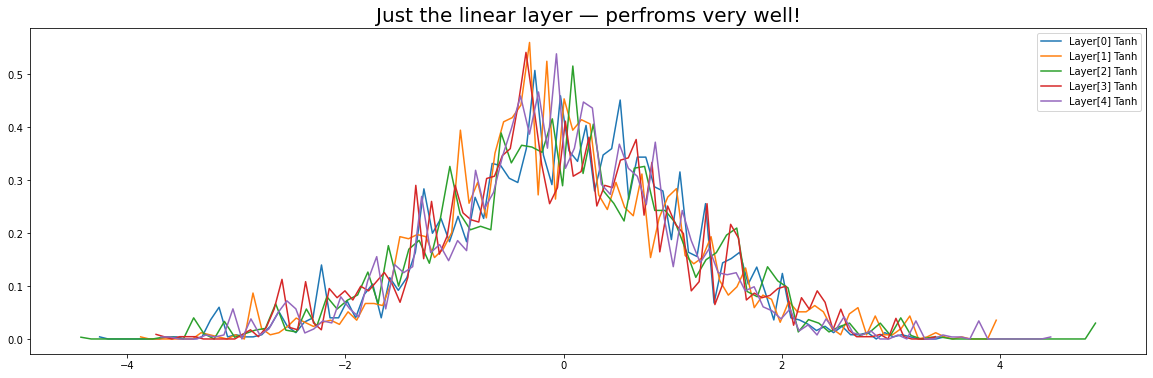

In [93]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        activation_applied = layer.out # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("Just the linear layer — perfroms very well!", fontsize=20);

Layer[0] — mean: 0.00	std: 0.00028
Layer[1] — mean: 0.00	std: 0.00028
Layer[2] — mean: -0.00	std: 0.00029
Layer[3] — mean: -0.00	std: 0.00031
Layer[4] — mean: -0.00	std: 0.00031


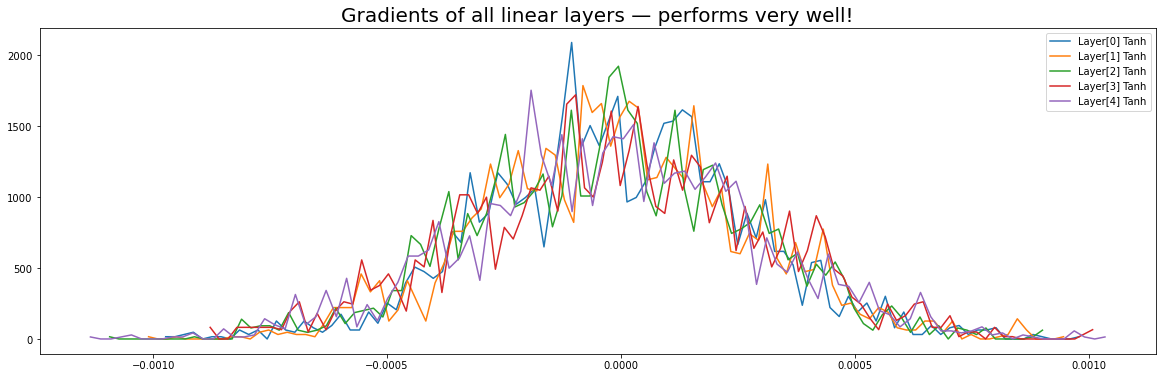

In [94]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        activation_applied = layer.out.grad # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("Gradients of all linear layers — performs very well!", fontsize=20);

## 🤔 So, why to include activations!?

As we can see, in the **simple** neural net, without any activation and also without **worrying** about the gains, we are **already getting** pretty good setting of the gradients and the values!

> ***So, why to add the activation and care about the gains!***

The simple reason is: *Without activations, no matter how many (linear) layers you include, they all mean the same thing. They all are equal to the single long linear layer*.

If you perform the **math** by hand:
1. Make a neural net of `3` linear layers and `50` neurons each. And perform the matrix multiplication. Store the result somewhere.
2. Make another net with `1` layer and `150` neurons. Perform the matrix multiplication. The result will be the same.

___
**Have asked ChatGPT too! Here is its response:**

🤖

In a neural network, information flows from the input layer through one or more hidden layers to the output layer. Each layer consists of multiple neurons (also called nodes or units), and the connections between neurons are represented by weights.

In a basic neural network architecture, if we were to remove the activation function from all the hidden layers and keep only linear layers, **the behavior of the network would be equivalent to a single linear layer**. This means that no matter how many hidden layers we have, **the output of the network would be a linear transformation of the input**.

To illustrate this, consider a simple neural network with one input layer, two hidden layers, and one output layer. Each layer has three neurons, and the connections are depicted by arrows:

```
Input Layer   Hidden Layer 1   Hidden Layer 2   Output Layer
    x1             a1,1            a2,1             y1
    x2             a1,2            a2,2             y2
    x3             a1,3            a2,3             y3
```

In this example, let's assume that each neuron in the hidden layers has a linear activation function (e.g., f(x) = x). Without any non-linear activation functions, **the output of each hidden layer would be a linear combination of its inputs**:

```
a1,1 = w1,1 * x1 + w2,1 * x2 + w3,1 * x3
a1,2 = w1,2 * x1 + w2,2 * x2 + w3,2 * x3
a1,3 = w1,3 * x1 + w2,3 * x2 + w3,3 * x3

a2,1 = w1,4 * a1,1 + w2,4 * a1,2 + w3,4 * a1,3
a2,2 = w1,5 * a1,1 + w2,5 * a1,2 + w3,5 * a1,3
a2,3 = w1,6 * a1,1 + w2,6 * a1,2 + w3,6 * a1,3
```

Then, **the output layer would also perform a linear combination of the hidden layer outputs**:

```
y1 = w1,7 * a2,1 + w2,7 * a2,2 + w3,7 * a2,3
y2 = w1,8 * a2,1 + w2,8 * a2,2 + w3,8 * a2,3
y3 = w1,9 * a2,1 + w2,9 * a2,2 + w3,9 * a2,3
```

As we can observe, **the entire network can be represented as a linear combination of the input features `x1`, `x2`, and `x3`**. In other words, **the network collapses into a single linear layer without any non-linear activation functions**. This severely limits the expressive power of the network, as it can only perform linear transformations of the input data and cannot capture more complex relationships or patterns.

Therefore, **the presence of non-linear activation functions is crucial to introduce non-linearity into the network**, allowing it to model and learn more intricate and sophisticated representations of the data.

___

# 🔏 Okay, now the important thing.

"Are we learning correctly"?

Weight shape: (28, 10) | Mean: 0.000 | Std: 0.001 | grad:data ratio 0.001
Weight shape: (30, 100) | Mean: -0.000 | Std: 0.002 | grad:data ratio 0.012
Weight shape: (100, 100) | Mean: -0.000 | Std: 0.002 | grad:data ratio 0.023
Weight shape: (100, 100) | Mean: -0.000 | Std: 0.002 | grad:data ratio 0.025
Weight shape: (100, 100) | Mean: -0.000 | Std: 0.003 | grad:data ratio 0.029
Weight shape: (100, 100) | Mean: 0.000 | Std: 0.003 | grad:data ratio 0.027
Weight shape: (100, 28) | Mean: 0.000 | Std: 0.047 | grad:data ratio 4.232


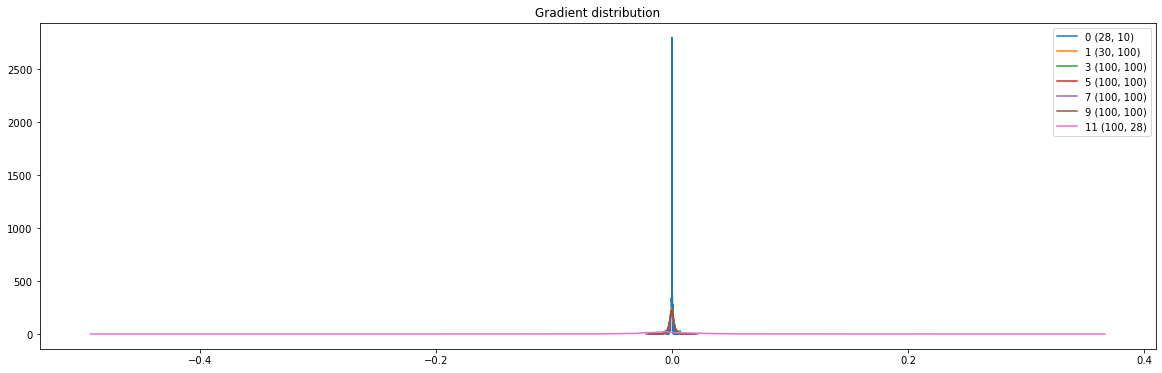

In [95]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # so that the bias is not printed :)
        print(f"Weight shape: {tuple(p.shape)} | Mean: {t.mean():.3f} | Std: {t.std():.3f} | grad:data ratio {t.std() / p.std():.3f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Gradient distribution");

**How/Why is this different than with `out.grad`?**:
- The `out.grad` is the forward pass aggregation of the values `x` + weights `p` and + bias `b` where we had the grads of weights and **also** grads of `out`.
- The trainable grads are of the weights `x` which are being endedup in the `parameters` variable and loss is counted upon. 
- Before the plot above, **we just** plotted the grads of the out, which were normal... here we are printing the grads of weights.

**The ratio should be small** because if the grads are larger in the magnitude than the **actual** weights, then the step updates will be messed up — but in the last layer **it is the case** 🚨

> 🙄<br>Because **such layer will be trained** faster than the other layers!! 

### 🚅 If we are looking for "how fast" the layer is trained... then why ratio!?

Correct, the **gradient-data ratio** may not provide valuable information, so we will see how fast each layer updates.

In [164]:
embeddings = torch.randn(vocab_size, n_embd, generator=generator)
layers = [
    Linear(n_embd * block_size, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, n_neurons), 
    Linear(n_neurons, vocab_size), 
]

In [165]:
with torch.no_grad():
    layers[-1].weight *= 0.1
    
    ### No gain was added... keeping the gain...
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 ### SEE?

In [166]:
parameters = [embeddings]
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)
        
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46608


In [167]:
losses = []
update_data = []
epochs = 1000 # just first 1000 steps

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = cross_entropy(x, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for layer in layers:
        layer.out.retain_grad() ### Just temproary
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    with torch.no_grad(): ### NEW CODE 👨‍💻 ###
        updates = []
        for p in parameters:
            update = learning_rate * p.grad.std() / p.data.std()
            update = update.log10().item() # for better viz
            updates.append(update)
        update_data.append(updates)
            
    losses.append(loss.item())

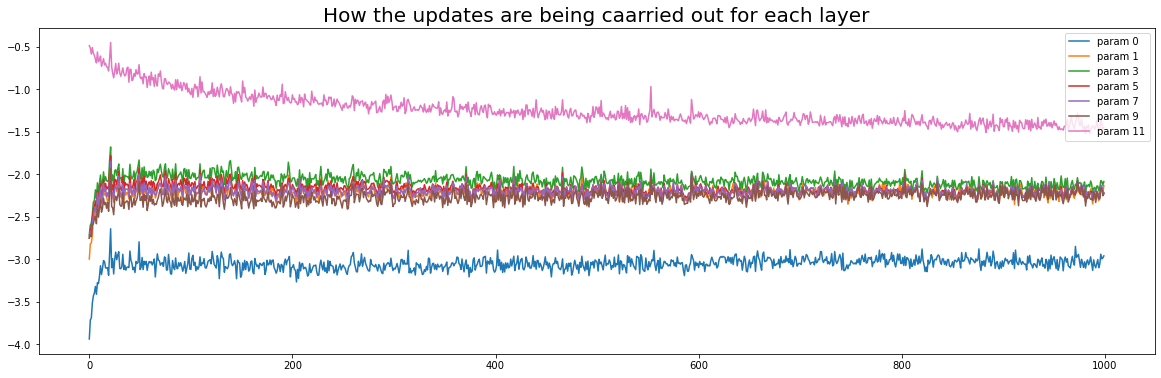

In [168]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data[j][i] for j in range(len(update_data))])
        legends.append(f"param {i}")
plt.legend(legends)
plt.title("How the updates are being caarried out for each layer", fontsize=20);

### Wait, any reference?
Yes, sure. We **need** some baseline to which we can compare the performance, **whether we are updating faster, slower** or what. That's what the **black** line is representing below.

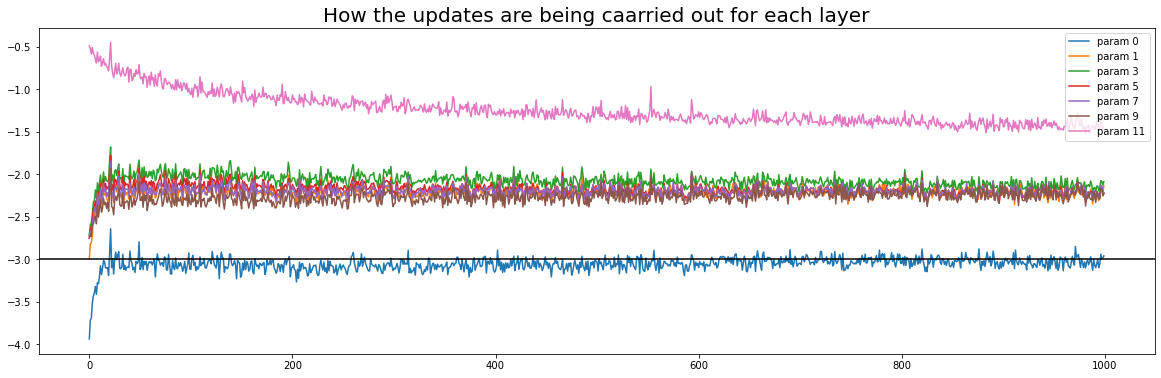

In [169]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data[j][i] for j in range(len(update_data))])
        legends.append(f"param {i}")
plt.axhline(-3, c='k')
plt.legend(legends)
plt.title("How the updates are being caarried out for each layer", fontsize=20);

There can be some more experiments which can be carried out, I've taken the screenshots to reduce the code :)

#### Very low learning rate `0.0001`

<img src="./Images/lr_00001.png">

#### High learning rate `0.5`

<img src="./Images/lr_05.png">

#### Very High learning rate `10.0`

<img src="./Images/lr_10.png">

#### Dynamic learning rate

<img src="./Images/lr_dynamic.png">

So, this is ***another way*** to get the proper learning rate! 😉

# 📦 BatchNorm - A Universal Aid

A lot of balancing was taking place:
- Adjusting gains if using activations
- No adjusting gains!? But at the cost of activations
- Saturations, update ratios all based on the initial settings.

But now, the **batch norm**. Just a simple addition in the structure ✨ how clean!

## `1.` With regular gain.

In [175]:
embeddings = torch.randn(vocab_size, n_embd, generator=generator)
layers = [
    Linear(n_embd * block_size, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, vocab_size), 
    BatchNorm1d(vocab_size)
]

In [176]:
with torch.no_grad():
    """No need to uniformize the last layer since now that
    is the BatchNorm. But we will change the gamma"""
    layers[-1].gamma *= 0.1
    
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 ### SEE?

In [177]:
parameters = [embeddings]
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)
        
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47664


In [178]:
losses = []
update_data = []
epochs = 1000 # just first 1000 steps

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = cross_entropy(x, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for layer in layers:
        layer.out.retain_grad() ### Just temproary
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    with torch.no_grad(): ### NEW CODE 👨‍💻 ###
        updates = []
        for p in parameters:
            update = learning_rate * p.grad.std() / p.data.std()
            update = update.log10().item() # for better viz
            updates.append(update)
        update_data.append(updates)
            
    losses.append(loss.item())

Layer[2] — mean: -0.00	std: 0.62	saturation: 3.44%
Layer[5] — mean: 0.00	std: 0.63	saturation: 3.56%
Layer[8] — mean: -0.00	std: 0.64	saturation: 2.66%
Layer[11] — mean: 0.00	std: 0.65	saturation: 1.94%
Layer[14] — mean: 0.01	std: 0.65	saturation: 2.38%


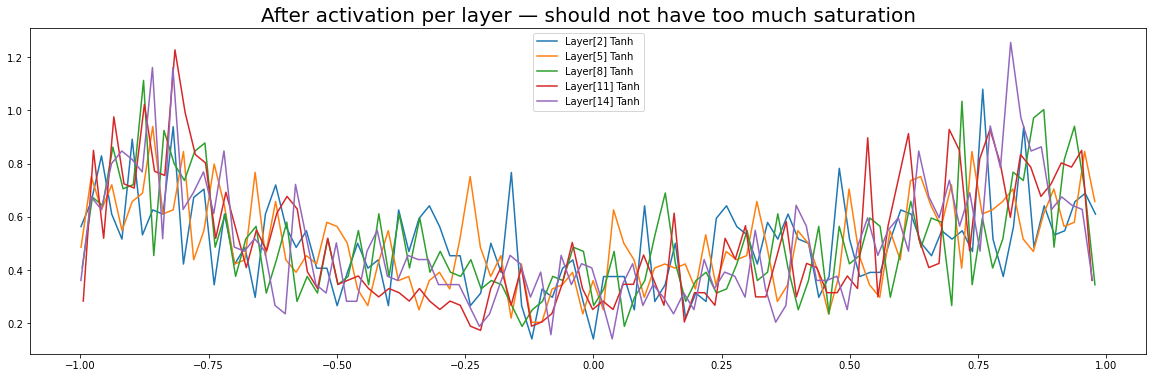

In [179]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        activation_applied = layer.out # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}\tsaturation: {(activation_applied.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("After activation per layer — should not have too much saturation", fontsize=20);

Layer[2] — mean: -0.00	std: 0.0035
Layer[5] — mean: 0.00	std: 0.0028
Layer[8] — mean: -0.00	std: 0.0025
Layer[11] — mean: -0.00	std: 0.0024
Layer[14] — mean: -0.00	std: 0.0024


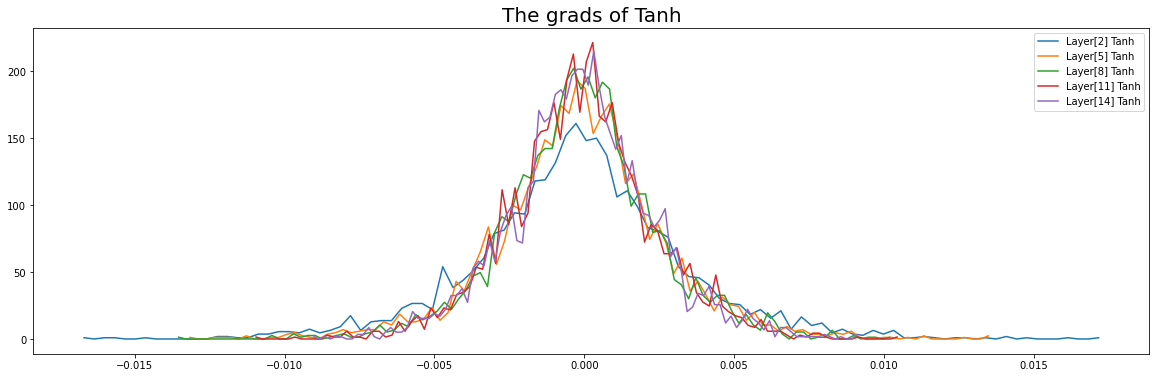

In [183]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        activation_applied = layer.out.grad # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("The grads of Tanh", fontsize=20);

Weight shape: (28, 10) | Mean: 0.000 | Std: 0.009 | grad:data ratio 0.010
Weight shape: (30, 100) | Mean: -0.000 | Std: 0.008 | grad:data ratio 0.026
Weight shape: (100, 100) | Mean: 0.000 | Std: 0.006 | grad:data ratio 0.037
Weight shape: (100, 100) | Mean: -0.000 | Std: 0.005 | grad:data ratio 0.031
Weight shape: (100, 100) | Mean: 0.000 | Std: 0.005 | grad:data ratio 0.029
Weight shape: (100, 100) | Mean: -0.000 | Std: 0.005 | grad:data ratio 0.028
Weight shape: (100, 28) | Mean: -0.000 | Std: 0.008 | grad:data ratio 0.049


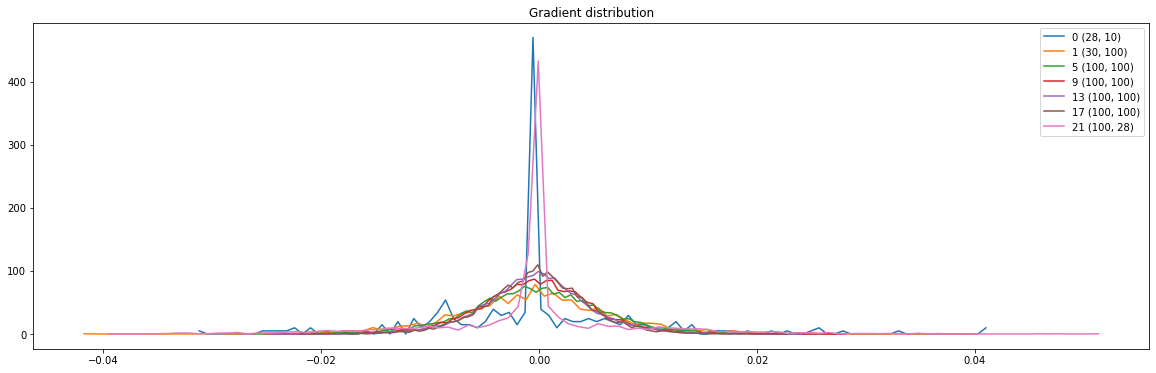

In [185]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # so that the bias is not printed :)
        print(f"Weight shape: {tuple(p.shape)} | Mean: {t.mean():.3f} | Std: {t.std():.3f} | grad:data ratio {t.std() / p.std():.3f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Gradient distribution");

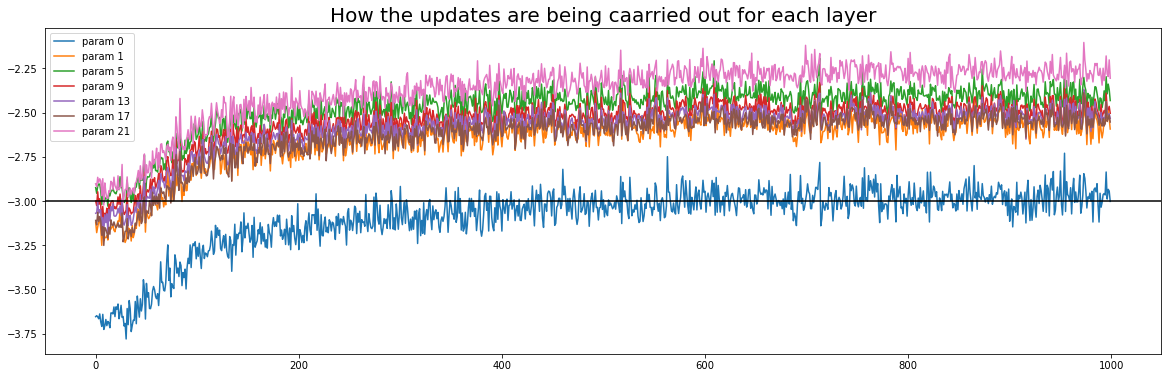

In [187]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data[j][i] for j in range(len(update_data))])
        legends.append(f"param {i}")
plt.legend(legends)
plt.axhline(-3, c='k')
plt.title("How the updates are being caarried out for each layer", fontsize=20);

All results are pretty good! ***with gain***.

## `2.` With some other gain.

In [188]:
embeddings = torch.randn(vocab_size, n_embd, generator=generator)
layers = [
    Linear(n_embd * block_size, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, n_neurons), 
    BatchNorm1d(n_neurons),
    Tanh(),
    
    Linear(n_neurons, vocab_size), 
    BatchNorm1d(vocab_size)
]

In [189]:
with torch.no_grad():
    """No need to uniformize the last layer since now that
    is the BatchNorm. But we will change the gamma"""
    layers[-1].gamma *= 0.1
    
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.1

In [190]:
parameters = [embeddings]
for layer in layers:
    for p in layer.parameters():
        parameters.append(p)
        
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47664


In [191]:
losses = []
update_data = []
epochs = 1000 # just first 1000 steps

for i in range(epochs):
    sample_idx = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=generator)
    
    # 1️⃣ Forward pass
    emb = embeddings[Xtrain[sample_idx]] 
    x = emb.view(-1, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = cross_entropy(x, ytrain[sample_idx]) 
    
    # 2️⃣ Backward
    for layer in layers:
        layer.out.retain_grad() ### Just temproary
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # 3️⃣ Update - with decay
    learning_rate = 0.1 if i < 10_000 else 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    with torch.no_grad(): ### NEW CODE 👨‍💻 ###
        updates = []
        for p in parameters:
            update = learning_rate * p.grad.std() / p.data.std()
            update = update.log10().item() # for better viz
            updates.append(update)
        update_data.append(updates)
            
    losses.append(loss.item())

Layer[2] — mean: -0.00	std: 0.65	saturation: 2.56%
Layer[5] — mean: 0.00	std: 0.66	saturation: 1.22%
Layer[8] — mean: 0.00	std: 0.67	saturation: 0.78%
Layer[11] — mean: 0.00	std: 0.68	saturation: 0.31%
Layer[14] — mean: -0.01	std: 0.68	saturation: 0.16%


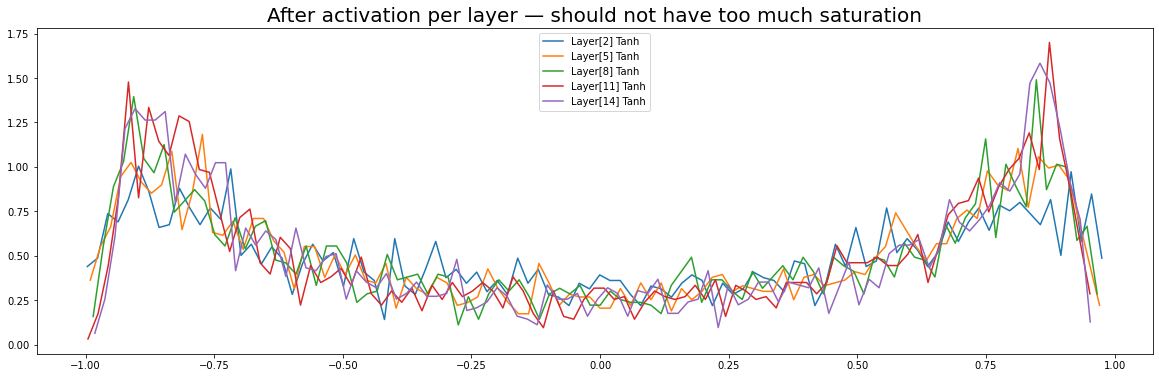

In [192]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        activation_applied = layer.out # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}\tsaturation: {(activation_applied.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("After activation per layer — should not have too much saturation", fontsize=20);

Layer[2] — mean: -0.00	std: 0.00093
Layer[5] — mean: -0.00	std: 0.00064
Layer[8] — mean: 0.00	std: 0.00057
Layer[11] — mean: 0.00	std: 0.00058
Layer[14] — mean: 0.00	std: 0.00068


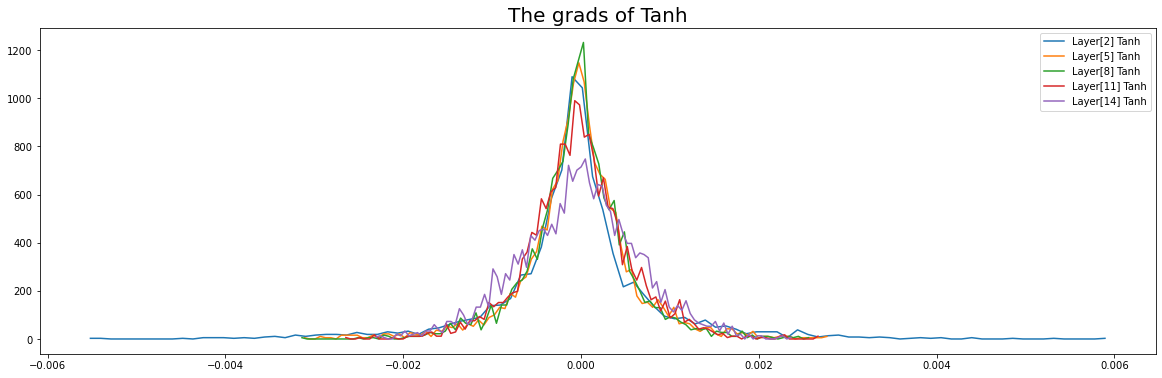

In [193]:
plt.figure(figsize=(20, 6))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        activation_applied = layer.out.grad # This is the matmuled value (after activation)
        print(f"Layer[{i}] — mean: {activation_applied.mean():.2f}\tstd: {activation_applied.std():.2}")
        hy, hx = torch.histogram(activation_applied, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer[{i}] Tanh")
plt.legend(legends)
plt.title("The grads of Tanh", fontsize=20);

Weight shape: (28, 10) | Mean: 0.000 | Std: 0.006 | grad:data ratio 0.006
Weight shape: (30, 100) | Mean: -0.000 | Std: 0.011 | grad:data ratio 0.230
Weight shape: (100, 100) | Mean: 0.000 | Std: 0.005 | grad:data ratio 0.235
Weight shape: (100, 100) | Mean: 0.000 | Std: 0.004 | grad:data ratio 0.226
Weight shape: (100, 100) | Mean: -0.000 | Std: 0.004 | grad:data ratio 0.219
Weight shape: (100, 100) | Mean: -0.000 | Std: 0.004 | grad:data ratio 0.216
Weight shape: (100, 28) | Mean: -0.000 | Std: 0.009 | grad:data ratio 0.244


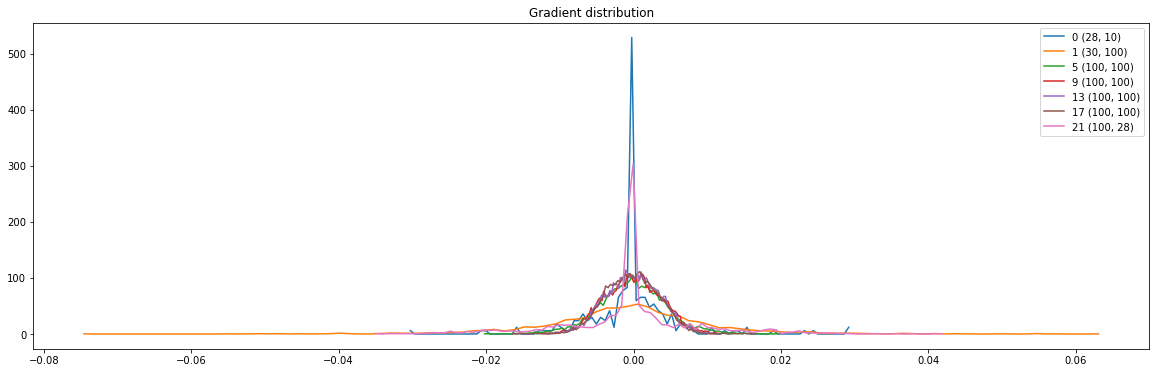

In [194]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # so that the bias is not printed :)
        print(f"Weight shape: {tuple(p.shape)} | Mean: {t.mean():.3f} | Std: {t.std():.3f} | grad:data ratio {t.std() / p.std():.3f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Gradient distribution");

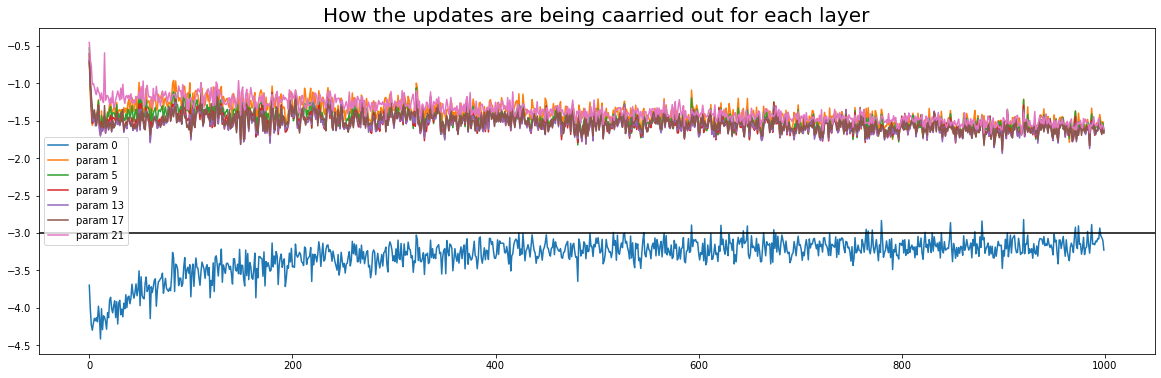

In [195]:
plt.figure(figsize=(20, 6))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_data[j][i] for j in range(len(update_data))])
        legends.append(f"param {i}")
plt.legend(legends)
plt.axhline(-3, c='k')
plt.title("How the updates are being caarried out for each layer", fontsize=20);

Still better! **not too horrific!!** 

> Just change some learning rate, and you will be good to go.

# 🖼 Summay - What to look for?

**Check whether the NN is in the good state of learning?**
- ☑ Check if the distribution of the gradients of activation layers are normal - if so tune the gain
- ☑ Check if the values of the activation layers are **not too saturated** - if so tune the gain
- ☑ Check for the gradients of the weights, there should not be much asymmetry.
- ☑ Check the data to gradient ratio and if much high, then there is some problem with learning rate and other things in the initialization
- ☑ Check the update rate
- ☑ Use batch norm to make the learning more robust to the small specifics!


# That's done!
I know in this lecture **we didn't built** any new model, but it was a hell lot of information with diagnostic tools and techniques to get out of the grad area. Let's move forward with another lecture packed with rich information on Backprop — the ninja 🐱‍👤